# Cleanup

This Jupyter notebook is the data cleaning pipeline to prepare the raw data from the Mongo Database to be used for the data analysis and the data visualisation on the dashboard. 

This script requires the following packages:

In [377]:
import sys
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import config
import datetime


In [378]:
pd.set_option('display.max_rows', None)

In [379]:
def GetScore(dataframe):
    print("Score per column:")
    for column in dataframe:
        _columnScore = (dataframe[column] == -1).sum()
        print("Column " + column + ": " + str(_columnScore))

In [349]:
df = df.drop('Unnamed: 0',axis=1)

## Fetching the Data

Fetching the raw sensor data from mongodb using secure connection. 

In [380]:
client = MongoClient(config.mongo_uri)

try:
    print('Available databases:')
    print(client.list_database_names())
except Exception:
    print("Unable to connect to the server.")

Available databases:
['smellStation', 'admin', 'local']


In [381]:
db = client.get_database('smellStation')

In [382]:
sensor_data = db.sensorData

In [383]:
df = pd.DataFrame(list(sensor_data.find()))

## Data Pre-processing

In [384]:
# Removing MongoDB id object
df = df.drop('_id', 1)

/var/folders/1n/bhlhgd8d6rxc39vc6_5lxy9w0000gn/T/ipykernel_1422/3325066838.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('_id', 1)


In [385]:
df.head()

,occupancy,bin1,bin2,H2S,temperature,humidity,timestamp
0,30,29.51,0.00,866,26.3,60.0,1638813600
1,27,28.97,0.00,902,28.1,35.0,1638814200
2,26,31.55,37.78,929,29.2,31.0,1638814800
3,25,-1.00,44.11,-1,-1.0,-1.0,1638815402
4,5,27.81,0.00,915,26.7,40.0,1638867600


In [386]:
# Rounding timestamp for cleaner time format

df["timestamp"] = round(df["timestamp"]/100)*100

In [387]:
df["timestamp"] = df["timestamp"].astype(int)

In [388]:
# df["date_time"] = pd.to_datetime(df['timestamp'], unit='s')
# df = df.drop("date_time",axis=1)
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
df['time'] = pd.to_datetime(df['timestamp'], unit='s').dt.time


In [389]:
# Removing first day of data as only 4 samples were taken

df = df.drop(labels=range(0,4), axis=0)


In [390]:
df = df.reset_index()

In [391]:
df = df.drop("index",axis=1)

In [392]:
# Interpolating missing data if only one datapoint is missing

for i in range(1, len(df)-1):
    for column in df:
        if (df.loc[i, column]) == -1:
            if df.loc[i+1,column] != -1 and df.loc[i-1,column] != -1:
                df.loc[i,column] = round((df.loc[i+1,column] + df.loc[i-1,column])/2)


In [393]:
df.head()

,occupancy,bin1,bin2,H2S,temperature,humidity,timestamp,date,time
0,5,27.81,0.0,915,26.7,40.0,1638867600,2021-12-07,09:00:00
1,6,29.48,0.0,843,26.3,30.0,1638868200,2021-12-07,09:10:00
2,6,37.06,0.0,826,27.6,26.0,1638868800,2021-12-07,09:20:00
3,6,-1.00,0.0,837,28.0,25.0,1638869400,2021-12-07,09:30:00
4,6,-1.00,0.0,834,28.0,26.0,1638870000,2021-12-07,09:40:00


In [399]:
# Verifying the number of empty or missing data points in each column

GetScore(df)

Score per column:
Column occupancy: 325
Column bin1: 128
Column bin2: 183
Column H2S: 787
Column temperature: 908
Column humidity: 908
Column timestamp: 0
Column date: 0
Column time: 0


<AxesSubplot:xlabel='timestamp', ylabel='H2S'>

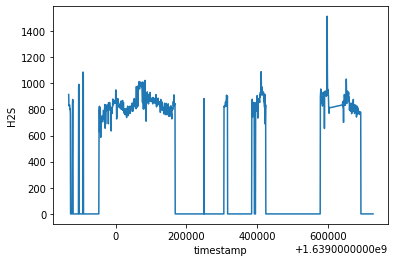

In [400]:
# Initial H2S plot

sns.lineplot(data=df, x="timestamp", y="H2S")

## Fully Cleaned Dataframe

A dataframe with no empty (-1) values was created to better analyse the data when every sensor was working correctly.

In [429]:
# Creating a dataframe with no mossing datapoints

df_cleaned = df
for column in df_cleaned:
    df_cleaned = df_cleaned[df_cleaned[column] != -1]


In [430]:
df_cleaned.head()

,occupancy,bin1,bin2,H2S,temperature,humidity,timestamp,date,time
0,5,27.81,0.0,915,26.7,40.0,1638867600,2021-12-07,09:00:00
1,6,29.48,0.0,843,26.3,30.0,1638868200,2021-12-07,09:10:00
2,6,37.06,0.0,826,27.6,26.0,1638868800,2021-12-07,09:20:00
5,7,25.61,0.0,832,27.8,26.0,1638870600,2021-12-07,09:50:00
6,13,27.00,0.0,800,29.3,21.0,1638871200,2021-12-07,10:00:00


In [431]:
df_cleaned = df_cleaned.drop("timestamp",axis=1)
# df_cleaned = df_cleaned.drop("date_time",axis=1)

In [432]:
len(df_cleaned)

389

In [433]:
from scipy import stats
for column in df_cleaned: 
    if (column != "date" and column != "time"):
        print(column)
        print(stats.pearsonr(df_cleaned['H2S'], df_cleaned[column]))

occupancy
(-0.060357100798169916, 0.23495942336125927)
bin1
(-0.25676942555191684, 2.8316553934057144e-07)
bin2
(-0.16087340435926173, 0.0014552219506377446)
H2S
(1.0, 0.0)
temperature
(0.19720602820901298, 9.021255381434366e-05)
humidity
(0.2733020048103918, 4.3102953280594573e-08)


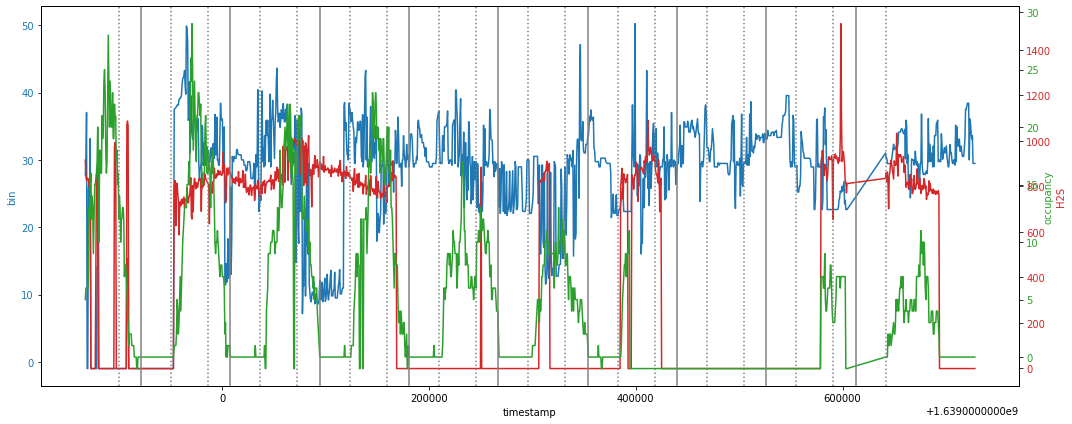

In [406]:

from scipy.signal import savgol_filter

fig, ax1 = plt.subplots(figsize=(15,6))

# smooth_H2S = savgol_filter(df["H2S"], 51, 3) # window size 51, polynomial order 3
# smooth_occupancy = savgol_filter(df["bin1"], 51, 3) # window size 51, polynomial order 3

smooth_H2S = df["H2S"]
smooth_occupancy = df["bin1"]

# plt.figure(figsize=(12, 6), dpi=80)

color = 'tab:blue'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('bin', color=color)
ax1.plot(df["timestamp"],smooth_occupancy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('H2S', color=color)  # we already handled the x-label with ax1
ax2.plot(df["timestamp"],smooth_H2S, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('occupancy', color=color)  # we already handled the x-label with ax1
ax3.plot(df["timestamp"],df["occupancy"], color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Creating lines for 8AM, 6PM and midnight
for i in range(9):
    plt.axvline(1639612800 - (86400 * i),0,1, color = "grey")
    plt.axvline(1639612800 - (86400 * i) + 28800,0,1, color = "grey", linestyle="dotted")
    plt.axvline(1639612800 - (86400 * i) - 21600,0,1, color = "grey", linestyle="dotted")

plt.show()


In [434]:
df_analysis = df_cleaned
df_analysis.head()

,occupancy,bin1,bin2,H2S,temperature,humidity,date,time
0,5,27.81,0.0,915,26.7,40.0,2021-12-07,09:00:00
1,6,29.48,0.0,843,26.3,30.0,2021-12-07,09:10:00
2,6,37.06,0.0,826,27.6,26.0,2021-12-07,09:20:00
5,7,25.61,0.0,832,27.8,26.0,2021-12-07,09:50:00
6,13,27.00,0.0,800,29.3,21.0,2021-12-07,10:00:00


In [435]:
len(df_analysis)

389

In [437]:
df_date_time = df_analysis[["time","date"]]

In [439]:
from scipy.stats import zscore

#normalising data
scaler = MinMaxScaler((0,100))
df_analysis[["bin1","bin2","H2S","temperature","humidity"]] = scaler.fit_transform(-df_analysis[["bin1","bin2","H2S","temperature","humidity"]])

#droping cols
df_analysis = df_analysis.drop("date", axis=1)
df_analysis = df_analysis.drop("time", axis=1)

#removing outliers
z_scores = stats.zscore(df_analysis)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2.5).all(axis=1)
df_analysis = df_analysis[filtered_entries]

In [440]:
df_analysis.head()

,occupancy,bin1,bin2,H2S,temperature,humidity
141,1,71.087719,47.931254,22.389666,62.222222,14.814815
142,1,71.415205,46.721833,25.726588,46.666667,18.518519
144,2,72.000000,49.220242,23.896663,28.888889,18.518519
145,5,72.421053,39.719924,24.542519,28.888889,18.518519
146,4,72.654971,58.545512,19.806243,35.555556,11.111111


In [441]:
for column in df_analysis:
    if column == "date":
        pass
    else:
        df_analysis[column] = df_analysis[column].astype(int)

In [442]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

df_analysis.corr(method=histogram_intersection)


,occupancy,bin1,bin2,H2S,temperature,humidity
occupancy,1.0,3699.0,3707.0,3656.0,3707.0,2880.0
bin1,3699.0,1.0,16084.0,9267.0,14626.0,7341.0
bin2,3707.0,16084.0,1.0,9581.0,14464.0,8259.0
H2S,3656.0,9267.0,9581.0,1.0,9405.0,6467.0
temperature,3707.0,14626.0,14464.0,9405.0,1.0,6650.0
humidity,2880.0,7341.0,8259.0,6467.0,6650.0,1.0


In [443]:
df_analysis = df_analysis.reset_index()
df_analysis = df_analysis.drop("index",axis=1)

In [444]:
df_analysis = pd.concat([df_analysis, df_date_time], axis=1, join="inner")
df_analysis.head()

,occupancy,bin1,bin2,H2S,temperature,humidity,time,date
0,1,71,47,22,62,14,09:00:00,2021-12-07
1,1,71,46,25,46,18,09:10:00,2021-12-07
2,2,72,49,23,28,18,09:20:00,2021-12-07
5,2,72,58,15,33,14,09:50:00,2021-12-07
6,5,74,47,12,35,11,10:00:00,2021-12-07


## Exporting CSV Data

For easy access to the data, the processed sensor data was both exported to the database as well a saved as a CSV file for local use. 

In [414]:
df.to_csv("Export_Data/data.csv", index = True, header=True)
df_cleaned.to_csv("Export_Data/cleanedData.csv", index = True, header=True)
df_analysis.to_csv("Export_Data/analysisData.csv", index = True, header=True)